In [1]:
import cv2, math,json,geopy.distance, os, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import fftpack
import seaborn as sns
from sklearn import metrics

In [10]:
class dataproc:
  def __init__(self,path):
    self.path = path
    self.n = 1

  def read_csv_format(self):
    df = pd.read_csv(self.path)
    
    return df
  
  def pick_random(self):
    # df is dataframe
    # n is the number of detectors to filter
    df = self.read_csv_format()
    unique_QTL = df['Position'].unique()
    select_QTLs = random.sample(unique_QTL.tolist(),self.n)
    df_filter = df[df['Position'].isin(select_QTLs)]
    return df_filter


  def visualize(self, df):
   fig, ax = plt.subplots(figsize=(10, 6))
   sns.lineplot(data=df, x='Generation', y='Frequency', hue='Position', ax=ax, legend=False)
        # Remove the left and bottom spines
   ax.spines['left'].set_visible(False)
   ax.spines['bottom'].set_visible(False)

        # Remove the ticks
   ax.tick_params(left=False, bottom=False)

        # Remove the axis labels
   plt.xlabel('')
   plt.ylabel('')

        # Remove the top and right spines using sns.despine()
   sns.despine(top=True, right=True)

        # Remove the x and y tick labels
   ax.set_xticklabels([])
   ax.set_yticklabels([])
        
   plt.show()

In [11]:
#path = "/home/etb68/YeastProj.dir/evogen-sims/ET_Yeast/output.dir/Select_Press/FSFP_4sd_1.dir/genomeFSFP4sd_A1_300_0.5.csv"
path ="/home/etb68/YeastProj.dir/evogen-sims/ET_Yeast/output.dir/Selection_Models/CSCP.dir/genome1_100_0.5.csv"
dp = dataproc(path)

In [12]:
df = dp.pick_random()

In [13]:
# df = pd.read_csv("/home/etb68/YeastProj.dir/evogen-sims/ET_Yeast/output.dir/Select_Press/FSFP_4sd_1.dir/genomeFSFP4sd_A1_300_0.5.csv")
# df.shape
# df.head()

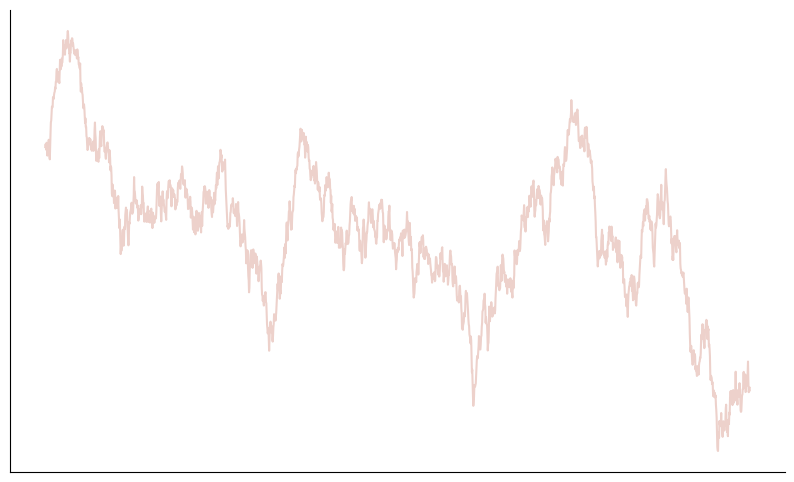

In [14]:
dp.visualize(df)

In [15]:
time_step = 1
sign = df['Frequency'].values.tolist()

In [16]:
# Fourier part

def fft_filter(sign,time_step, plot):
  #power of frequencies
  fft_sig = fftpack.fft(sign) #Strength of frequencies
  power = np.abs(fft_sig) # Power
  ## get corresponding frequecies
  sample_freq = fftpack.fftfreq((np.array(sign)).size, d=time_step)
  print (sample_freq)
  # area = 

  # get only positive frequencies
  #pos_mask = np.where(sample_freq > 0)# This gives you indices that are greater than zero
  pos_mask = np.where(sample_freq > 0.01)
  # pos_mask = np.where((sample_freq > 0)&(sample_freq < 0.05))
  freqs = sample_freq[pos_mask] #Freq that are greater than zero
  # # print (max(freqs),power[pos_mask].argmax())
  peak_indx = power[pos_mask].argmax()
  peak_freq = freqs[power[pos_mask].argmax()]
  print (peak_freq)

  ## with 509 points per day
  ## multiply 509 by peak_freq to get cycle per day. 

  # # print (peak_freq,power[pos_mask].max())
  # # plt.plot(sample_freq, power)
  # # print (power[pos_mask].mean())
  if plot:
    ## plot frequencies against strength
      plt.plot(sample_freq[pos_mask], power[pos_mask])#[0:100]
      # plt.plot(sample_freq, power) 
      # plt.plot(sample_freq, power)
      plt.show()

  # copy the frequency signal
  copy_freq_fft = fft_sig.copy()
  # # print ('peak frequency is: ' + str(peak_freq))
  
  ## select low frequencies
  #copy_freq_fft[np.abs(sample_freq) > 0.01] = 0
  copy_freq_fft[np.abs(sample_freq) > 0.05] = 0 #Setting the treshold freq
  #copy_freq_fft[np.abs(sample_freq) > peak_freq*1.5] = 0
  #copy_freq_fft[np.abs(sample_freq) > peak_freq*20] = 0
  #copy_freq_fft[np.abs(sample_freq) > peak_freq/2] = 0
  lf_signal = fftpack.ifft(copy_freq_fft) #Inverse fourier transformation. It takes us back to the signal
  return lf_signal#, sample_freq

[ 0.          0.00050025  0.0010005  ... -0.00150075 -0.0010005
 -0.00050025]
0.014007003501750874


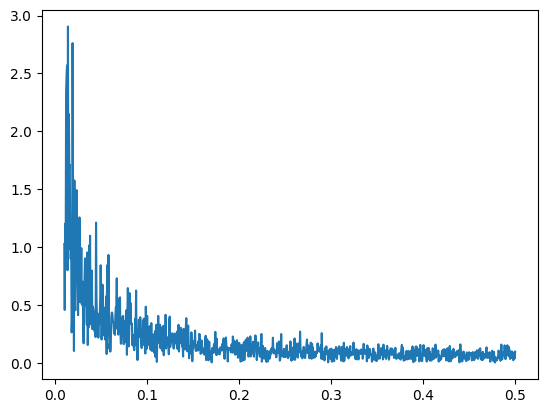

In [17]:
#df['Frequency'].size
lf_signal = fft_filter(sign, 1, 1)#sample_freq


In [22]:
# plt.plot(sample_freq, power)

In [23]:
# plt.plot(sample_freq)

[ 0.          0.00050025  0.0010005  ... -0.00150075 -0.0010005
 -0.00050025]
0.012006003001500749


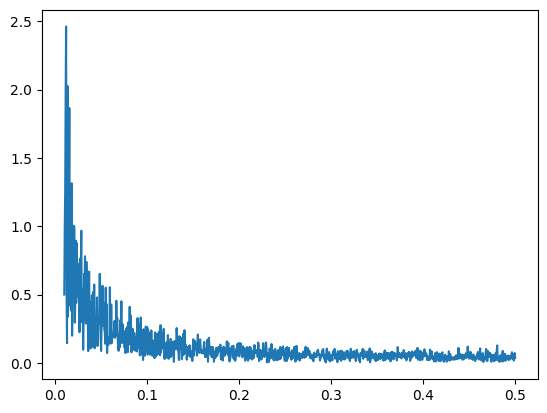

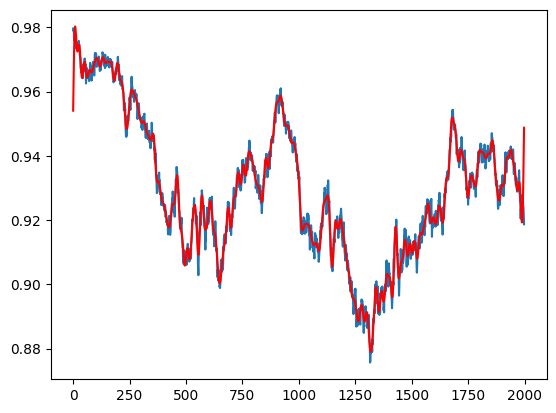

In [24]:
lf_signal = fft_filter(sign,1, 1)
plt.plot(sign)
plt.plot(lf_signal,'r')

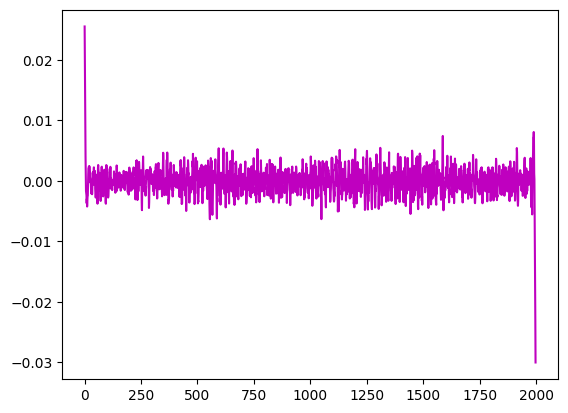

In [25]:
plt.plot((sign - lf_signal),'m')

(array([ 18., 104., 143., 309., 404., 339., 286., 153., 160.,  83.]),
 array([0.8757 , 0.88609, 0.89648, 0.90687, 0.91726, 0.92765, 0.93804,
        0.94843, 0.95882, 0.96921, 0.9796 ]),
 <BarContainer object of 10 artists>)

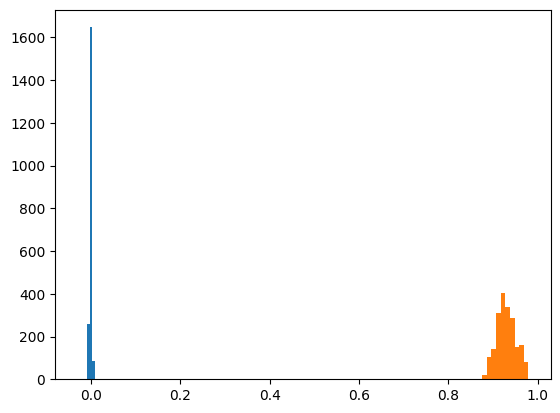

In [26]:
plt.hist(sign - lf_signal)
plt.hist(sign)

In [27]:
def get_low_freq(fft_sig, peak_freq, sample_freq, freqs, peak_indx):
  max_freq = max(freqs)
  lf_signals = []
  low_freqs = [0, peak_freq/4, peak_freq/2, peak_freq, peak_freq*2, peak_freq*4]
  print ('low frequency components\n')
  for cur_freq, next_freq in zip(low_freqs[0:-1],low_freqs[1:]):
    start_freq = cur_freq; end_freq = next_freq
    copy_freq_fft = fft_sig.copy()
    print ('frequency range is: ' +str(start_freq) +'-'+ str(end_freq))
    copy_freq_fft[np.abs(sample_freq) <start_freq] = 0
    copy_freq_fft[np.abs(sample_freq) >end_freq] = 0
    lf_signal = fftpack.ifft(copy_freq_fft)
    lf_signals.append(lf_signal)
  print ('\n')
  return lf_signals

def get_high_freq(fft_sig,peak_freq, sample_freq, freqs,peak_indx):

  max_freq = max(freqs)
  lf_signals = []
  low_freqs = [peak_freq*20,peak_freq*40,peak_freq*80,peak_freq*160,max_freq]

  print ('high frequency components\n')
  for cur_freq,next_freq in zip(low_freqs[0:-1],low_freqs[1:]):
    start_freq = cur_freq; end_freq = next_freq
    copy_freq_fft = fft_sig.copy()
    print ('frequency range is: ' +str(start_freq) +'-'+ str(end_freq))
    copy_freq_fft[np.abs(sample_freq) < start_freq] = 0
    copy_freq_fft[np.abs(sample_freq) > end_freq] = 0
    lf_signal = fftpack.ifft(copy_freq_fft)
    lf_signals.append(lf_signal)
    
  print ('\n')
    
  return lf_signals

def multiscale_fft(sign,time_step):
    fft_sig = fftpack.fft(sign)
    power = np.abs(fft_sig)
    ## get corresponding frequecies
    sample_freq = fftpack.fftfreq((np.array(sign)).size, d=time_step)
    pos_mask = np.where(sample_freq > 0)
    # pos_mask = np.where((sample_freq > 0)&(sample_freq < 0.05))
    freqs = sample_freq[pos_mask]
    # print (max(freqs),power[pos_mask].argmax())
    peak_indx = power[pos_mask].argmax()
    peak_freq = freqs[power[pos_mask].argmax()]

    low_filtered_sigs = get_low_freq(fft_sig,peak_freq, sample_freq, freqs,peak_indx)
    high_filtered_sigs = get_high_freq(fft_sig,peak_freq, sample_freq, freqs,peak_indx)
    return sample_freq, pos_mask, power, low_filtered_sigs,high_filtered_sigs

In [28]:
sample_freq, pos_mask, power, low_filtered_sigs,high_filtered_sigs = multiscale_fft(sign,1)

low frequency components

frequency range is: 0-0.0001250625312656328
frequency range is: 0.0001250625312656328-0.0002501250625312656
frequency range is: 0.0002501250625312656-0.0005002501250625312
frequency range is: 0.0005002501250625312-0.0010005002501250625
frequency range is: 0.0010005002501250625-0.002001000500250125


high frequency components

frequency range is: 0.010005002501250625-0.02001000500250125
frequency range is: 0.02001000500250125-0.0400200100050025
frequency range is: 0.0400200100050025-0.080040020010005
frequency range is: 0.080040020010005-0.4997498749374687




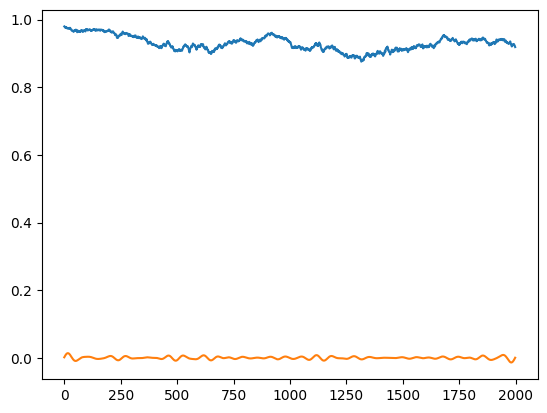

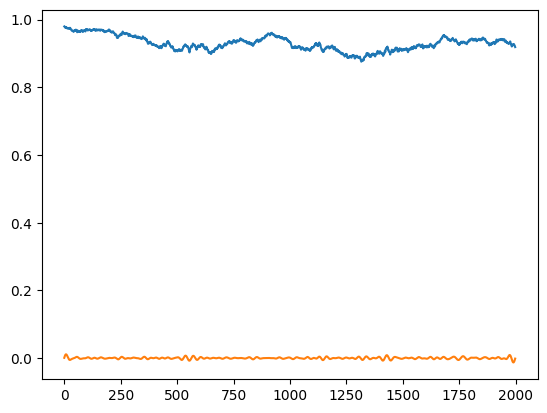

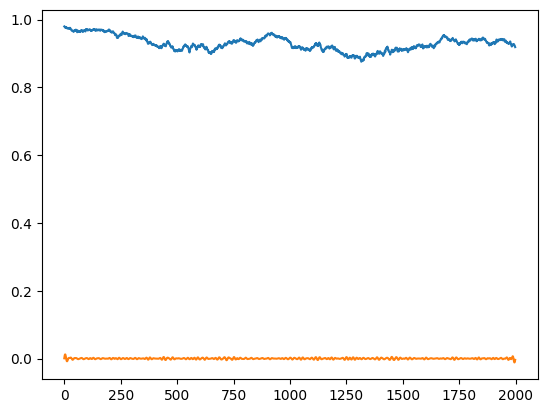

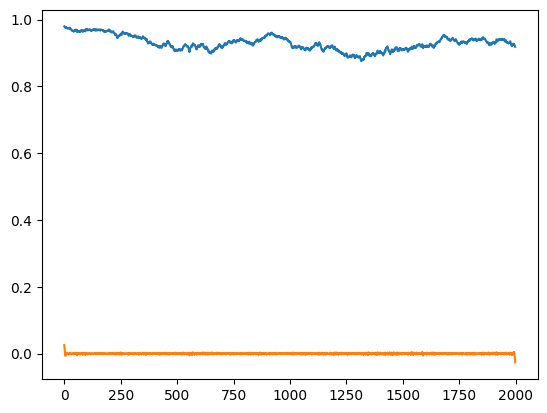

In [29]:
for filt in high_filtered_sigs:
  plt.plot(sign)
  plt.plot(filt)

  plt.show()

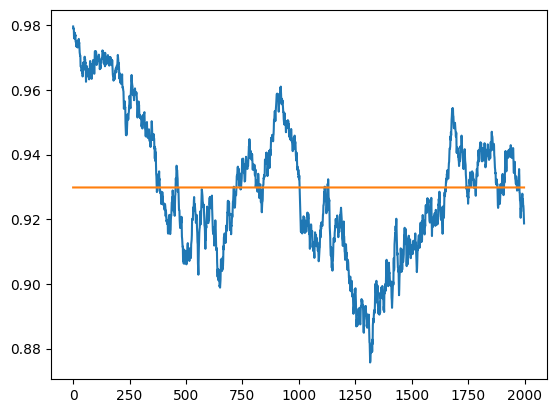

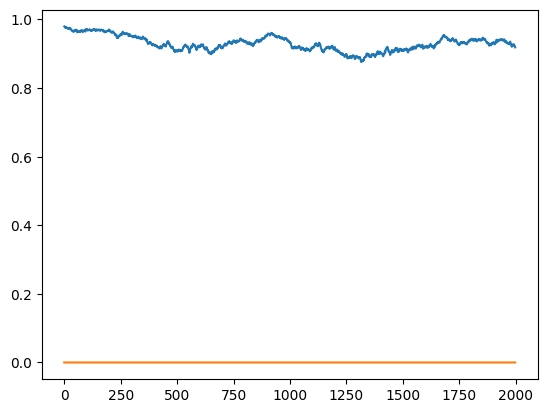

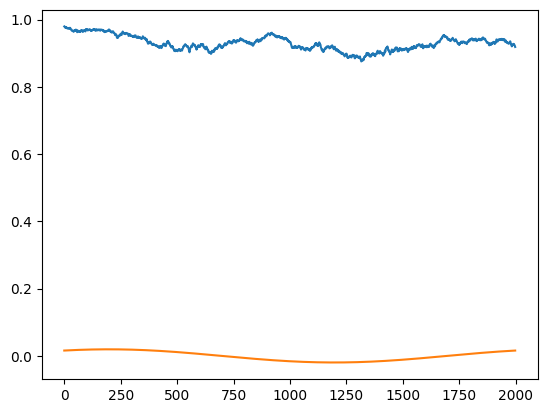

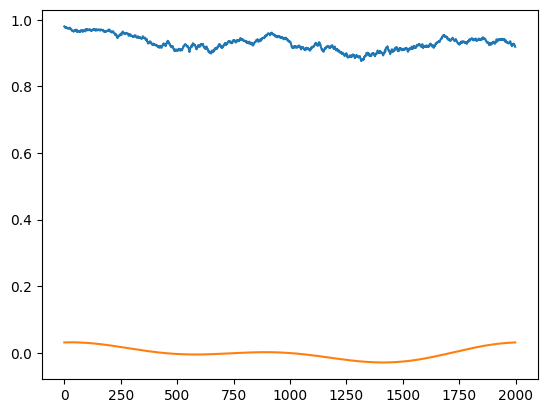

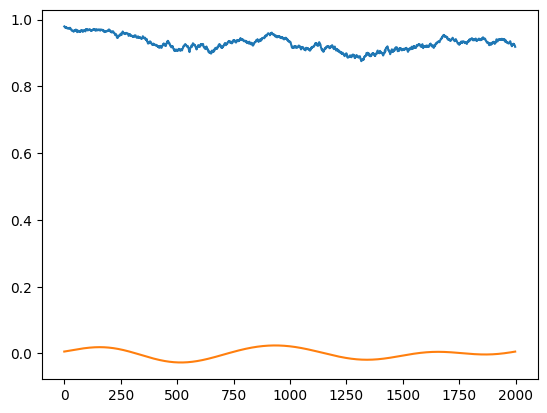

In [30]:
for filt in low_filtered_sigs:
  plt.plot(sign)
  plt.plot(filt)
  plt.show()